In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from numpy import mean
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stns = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurements.date).order_by(measurements.date.desc()).first()

('2017-08-23',)

Query Date:  2016-08-23


([<matplotlib.axis.XTick at 0x7fb8db59ead0>,
 <a list of 5 Text xticklabel objects>)

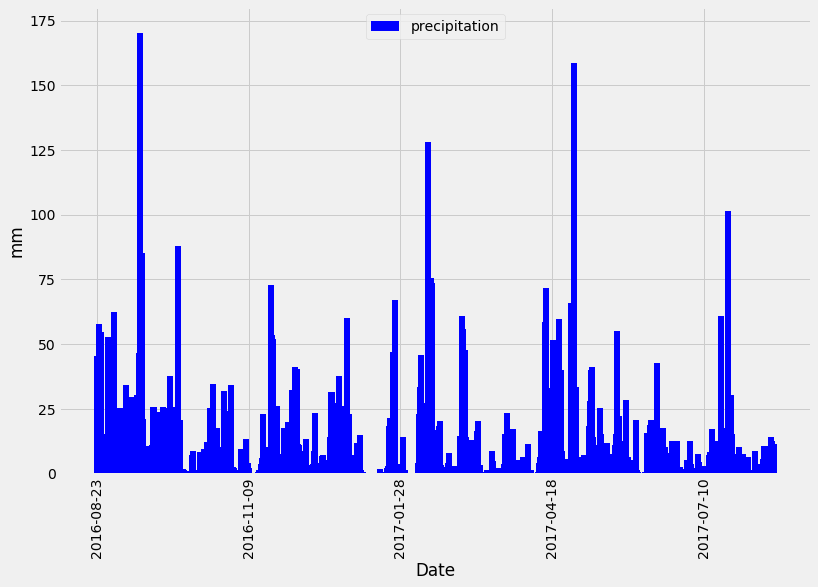

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(measurements.date, measurements.prcp).\
                filter(measurements.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.read_sql_query(sql = session.query(measurements.date, measurements.prcp).
                             filter(measurements.date >= query_date).statement, con=engine)
query_df = query_df.reset_index(drop=True)
query_df = query_df.set_index('date')

# Sort the dataframe by date
query_df = query_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12,8))
x_axis = np.arange(len(query_df['prcp']))
tick_locations = [0, 500, 1000, 1500, 2000]
xticklabels = ["2016-08-23","2016-11-09","2017-01-28","2017-04-18","2017-07-10"]
plt.bar(x_axis, query_df['prcp'], label = 'precipitation', color='b',align="center", width=20)
plt.ylim(0, max(query_df['prcp'])+10)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend(loc='upper center')
plt.xticks(tick_locations, xticklabels, rotation="90")

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
query_df.describe()

,prcp
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(stns.station).distinct().count()
print(f"The total number of stations in the dataset is {total_stations}")

The total number of stations in the dataset is 9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurements.station,
              func.count(measurements.station).label('Qty')
             ).group_by(measurements.station
             ).order_by(desc('Qty')).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Find the station ID for the most active station from the previous query
conn = engine.connect()
pd.read_sql("SELECT * FROM station WHERE station = 'USC00519281'", conn)

,id,station,name,latitude,longitude,elevation
0,6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurements.id, measurements.station, measurements.date, measurements.prcp, measurements.tobs]
active_q = session.query(*sel).filter(measurements.station == stns.station, stns.id == 6).all()
analysis = session.query(measurements.station, func.min(measurements.tobs),func.max(measurements.tobs),
                         func.avg(measurements.tobs)).\
                        filter(measurements.station == stns.station, stns.id == 6).all()
print(f"The most active station ID, lowest temperature, highest temperature and average temperature are\n\
{analysis}")


The most active station ID, lowest temperature, highest temperature and average temperature are
[('USC00519281', 12.2, 29.4, 22.03582251082252)]


In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(measurements.date).\
filter(measurements.station == stns.station, stns.id == 6).order_by(measurements.date.desc()).first()

('2017-08-18',)

In [17]:
querytemp_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print(f"Query Date for Temperature observation: {querytemp_date}")

Query Date for Temperature observation: 2016-08-18


In [18]:
# Retrieve the temperature data for the station of interest
temp_data = pd.read_sql("SELECT tobs FROM measurement WHERE station = 'USC00519281' AND date >= '2016-08-18'", conn)
temp_data

,tobs
0,26.7
1,26.1
2,27.2
3,26.1
4,25.6
...,...
352,25.0
353,25.0
354,24.4
355,24.4


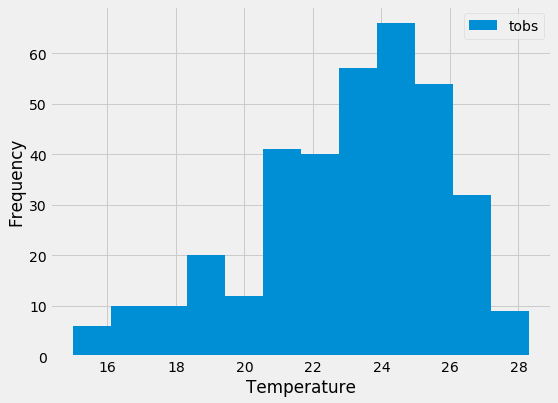

In [19]:
hist = temp_data.hist(bins=12, label = 'tobs', figsize = (8,6))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("")
plt.legend(loc='upper right')

# Close session

In [20]:
# Close Session
session.close()